# Course Project - Data Imputation - GP
## Zahra Samet

**Data Setup**

In [3]:
import numpy as np
from scipy.io import loadmat

# Load the .mat file (contains BOTH training and test tensors)
data = loadmat("MODIS_Aug.mat")

# Print keys inside the .mat file to confirm
print("Keys inside MAT file:", data.keys())

# Extract tensors
train = data["training_tensor"]   # shape: (100, 200, 31)
test  = data["test_tensor"]       # shape: (100, 200, 31)

print("Training tensor shape:", train.shape)
print("Test tensor shape:", test.shape)

Keys inside MAT file: dict_keys(['__header__', '__version__', '__globals__', 'test_tensor', 'training_tensor'])
Training tensor shape: (100, 200, 31)
Test tensor shape: (100, 200, 31)


In [4]:
# Mask of observed data (True where observed)
mask_obs = train != 0

n_total = train.size
n_obs   = np.count_nonzero(mask_obs)
n_miss  = n_total - n_obs

print(f"Total entries:   {n_total}")
print(f"Observed entries: {n_obs}  ({n_obs/n_total:.2%})")
print(f"Missing entries:  {n_miss}  ({n_miss/n_total:.2%})")

# Statistics of observed values (in Kelvin)
vals = train[mask_obs]
print("Observed LST stats (K):")
print(f"  min:  {vals.min():.2f}")
print(f"  max:  {vals.max():.2f}")
print(f"  mean: {vals.mean():.2f}")
print(f"  std:  {vals.std():.2f}")

Total entries:   620000
Observed entries: 494762  (79.80%)
Missing entries:  125238  (20.20%)
Observed LST stats (K):
  min:  279.00
  max:  339.00
  mean: 314.29
  std:  8.72


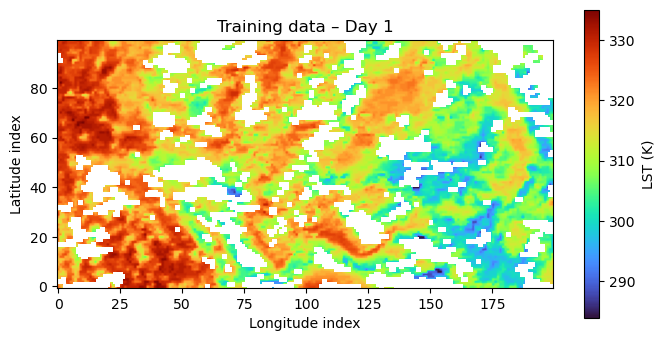

In [5]:
### A map for a single day ###

import matplotlib.pyplot as plt

# Choose a day index (0-based): day 0
day_idx = 0

# Data for that day
day_data = train[:, :, day_idx]
day_mask = mask_obs[:, :, day_idx]

# Mask out missing values so they appear as white
day_data_masked = np.ma.masked_where(~day_mask, day_data)

plt.figure(figsize=(8, 4))
im = plt.imshow(day_data_masked, origin='lower', cmap='turbo')
plt.colorbar(im, label='LST (K)')
plt.title(f'Training data – Day {day_idx+1}')
plt.xlabel('Longitude index')
plt.ylabel('Latitude index')
plt.show()


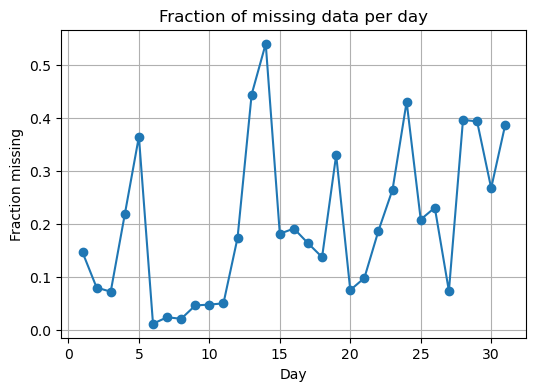

In [6]:
### Fraction of missing per day ###

missing_per_day = (~mask_obs).reshape(-1, train.shape[2]).mean(axis=0)

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, train.shape[2]+1), missing_per_day, '-o')
plt.xlabel('Day')
plt.ylabel('Fraction missing')
plt.title('Fraction of missing data per day')
plt.grid(True)
plt.show()


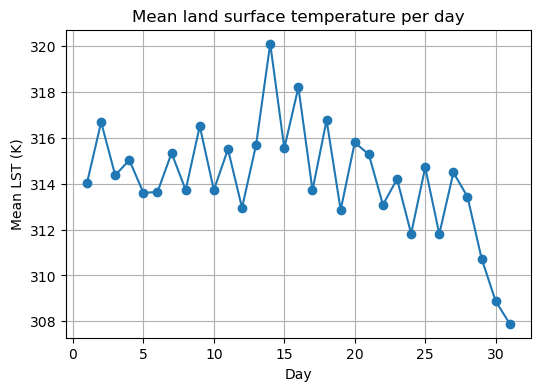

In [7]:
### The mean temperature per day to see temporal evolution ###

mean_temp_per_day = np.where(mask_obs, train, np.nan).reshape(-1, train.shape[2])
mean_temp_per_day = np.nanmean(mean_temp_per_day, axis=0)

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, train.shape[2]+1), mean_temp_per_day, '-o')
plt.xlabel('Day')
plt.ylabel('Mean LST (K)')
plt.title('Mean land surface temperature per day')
plt.grid(True)
plt.show()


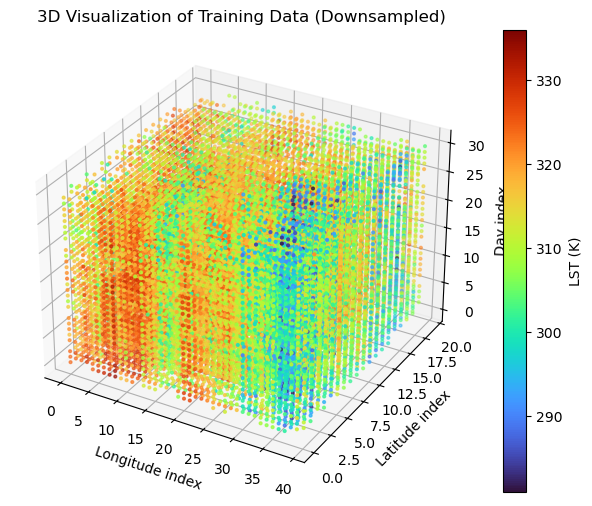

In [8]:
# 3D scatter of all days (downsampled)
ds = 5  # pick every 5th pixel to avoid 600k points

lat, lon, day = np.where(mask_obs[::ds, ::ds, ::1])  # coordinates
vals = train[::ds, ::ds, ::1][mask_obs[::ds, ::ds, ::1]]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(lon, lat, day, c=vals, cmap='turbo', s=4)

fig.colorbar(p, ax=ax, label="LST (K)")
ax.set_xlabel("Longitude index")
ax.set_ylabel("Latitude index")
ax.set_zlabel("Day index")
ax.set_title("3D Visualization of Training Data (Downsampled)")
plt.show()


**GP**

**Separating Along lat, lon, day**

In [11]:
nx, ny, nt = train.shape  # (100, 200, 31)
print("Grid size:", nx, ny, nt)

Grid size: 100 200 31


In [12]:
# 1D coordinates (normalized indices)
lat_idx  = np.arange(nx)
lon_idx  = np.arange(ny)
time_idx = np.arange(nt)

lat  = (lat_idx  - lat_idx.mean())  / lat_idx.std()
lon  = (lon_idx  - lon_idx.mean())  / lon_idx.std()
time = (time_idx - time_idx.mean()) / time_idx.std()

In [13]:
# fit 1D GP with RBF + noise
from scipy.sparse.linalg import cg, LinearOperator
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel

# Choose kernel type: "rbf", "matern32", or "matern12"
# kernel_type = "rbf"        # current
# kernel_type = "matern32"  # Matérn ν=1.5
# kernel_type = "matern12"  # Matérn ν=0.5

# Kernel choices
kernel_type_space = "matern12"       # "rbf" or "matern12"
kernel_type_time  = "combo"        # "rbf" or "matern12" or "combo"

def fit_1d_gp(X, y, dim_name="", kernel_type="rbf"):
    """
    Fit 1D GP with RBF + White kernel using sklearn.
    X: (n,1) coordinates
    y: (n,) values
    Returns: (lengthscale, variance, noise_variance)
    
    Kernel: k(x,x') = σ² exp( -0.5 (|x-x'|/ℓ)^2 ) + σ_n² δ(x,x')
    """
# Base kernel depending on choice
    if kernel_type == "rbf":
        base = RBF(length_scale=1.0)
    elif kernel_type == "matern32":
        base = Matern(length_scale=1.0, nu=1.5)
    elif kernel_type == "matern12":
        base = Matern(length_scale=1.0, nu=0.5)
    else:
        raise ValueError(f"Unknown kernel_type: {kernel_type}")

    kernel = 1.0 * base + WhiteKernel(noise_level=1.0)

    gp = GaussianProcessRegressor(kernel=kernel,
                                  n_restarts_optimizer=3,
                                  normalize_y=True,
                                  random_state=0)
    gp.fit(X, y)

    k_opt = gp.kernel_
    const_k = k_opt.k1.k1       # ConstantKernel
    base_k  = k_opt.k1.k2       # RBF or Matern
    white_k = k_opt.k2          # WhiteKernel

    var      = float(const_k.constant_value)
    length   = float(base_k.length_scale)
    noiseVar = float(white_k.noise_level)

    print(f"[{dim_name}] ({kernel_type}) lengthscale={length:.3f}, var={var:.3f}, noise={noiseVar:.3f}")
    return length, var, noiseVar
    

In [14]:
# Build 1D training data for each dimension (keep only observed values)

# --- X dimension (longitude) ---
best_count = -1
best_iy, best_it = None, None

for iy in range(nx):
    for it in range(nt):
        count = np.count_nonzero(mask_obs[iy, :, it])
        if count > best_count:
            best_count = count
            best_iy, best_it = iy, it

print("Best slice for X (lon): lat index =", best_iy, ", time index =", best_it, ", obs =", best_count)

mask_line_x = mask_obs[best_iy, :, best_it]   # (ny,)
y_line_x    = train[best_iy, :, best_it]      # (ny,)

Xx = lon[mask_line_x][:, None]   # observed lon coords
yx = y_line_x[mask_line_x]       # observed temps
print("1D X data size:", Xx.shape[0])


Best slice for X (lon): lat index = 0 , time index = 5 , obs = 200
1D X data size: 200


In [15]:
# --- Y dimension (latitude) ---
best_count = -1
best_ix, best_it = None, None

for ix in range(ny):
    for it in range(nt):
        count = np.count_nonzero(mask_obs[:, ix, it])
        if count > best_count:
            best_count = count
            best_ix, best_it = ix, it

print("Best slice for Y (lat): lon index =", best_ix, ", time index =", best_it, ", obs =", best_count)

mask_line_y = mask_obs[:, best_ix, best_it]   # (nx,)
y_line_y    = train[:, best_ix, best_it]      # (nx,)

Xy = lat[mask_line_y][:, None]
yy = y_line_y[mask_line_y]
print("1D Y data size:", Xy.shape[0])


Best slice for Y (lat): lon index = 0 , time index = 1 , obs = 100
1D Y data size: 100


In [16]:
# --- T dimension (time) ---
best_count = -1
best_iy, best_ix = None, None

for iy in range(nx):
    for ix in range(ny):
        count = np.count_nonzero(mask_obs[iy, ix, :])
        if count > best_count:
            best_count = count
            best_iy, best_ix = iy, ix

print("Best slice for T (time): lat index =", best_iy, ", lon index =", best_ix, ", obs =", best_count)

mask_line_t = mask_obs[best_iy, best_ix, :]   # (nt,)
y_line_t    = train[best_iy, best_ix, :]      # (nt,)

Xt = time[mask_line_t][:, None]
yt = y_line_t[mask_line_t]
print("1D T data size:", Xt.shape[0])


Best slice for T (time): lat index = 6 , lon index = 16 , obs = 31
1D T data size: 31


In [17]:
# Fit 1D GPs and get hyperparameters

ell_x, var_x, noise_x = fit_1d_gp(Xx, yx, dim_name="X (lon)")
ell_y, var_y, noise_y = fit_1d_gp(Xy, yy, dim_name="Y (lat)")
ell_t, var_t, noise_t = fit_1d_gp(Xt, yt, dim_name="T (time)")

# Use an average noise variance for the full 3D GP
noise_var = float(np.mean([noise_x, noise_y, noise_t]))
print("Global noise variance for 3D GP:", noise_var)


[X (lon)] (rbf) lengthscale=0.039, var=0.751, noise=0.055
[Y (lat)] (rbf) lengthscale=0.467, var=0.837, noise=0.271
[T (time)] (rbf) lengthscale=1.973, var=0.693, noise=0.719
Global noise variance for 3D GP: 0.34799350394084555


In [18]:
# Build 1D covariance matrices Kx, Ky, Kt with RBF or Matérn
def kernel_1d(x, lengthscale, variance, kernel_type="rbf"):
    """
    Build 1D covariance matrix for the given kernel.
    """
    x = np.asarray(x)[:, None]
    dists = np.abs(x - x.T)
    d2    = dists**2

    if kernel_type == "rbf":
        K = variance * np.exp(-0.5 * d2 / (lengthscale**2))

    elif kernel_type == "matern32":
        sqrt3_r_over_l = np.sqrt(3) * dists / lengthscale
        K = variance * (1.0 + sqrt3_r_over_l) * np.exp(-sqrt3_r_over_l)

    elif kernel_type == "matern12":
        K = variance * np.exp(-dists / lengthscale)

    else:
        raise ValueError(f"Unknown kernel_type: {kernel_type}")

    return K

### for the combo case:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, DotProduct, WhiteKernel

def fit_time_combo_gp(Xt, yt):
    """
    Build a richer time kernel: RBF + linear + periodic + noise.
    Xt should be shape (nt, 1), yt are observed time samples.
    Returns: Kt (nt x nt), noise_t
    """
    kernel_t = (
        1.0 * RBF(length_scale=5.0) +              # smooth temporal trend
        0.5 * DotProduct(sigma_0=1.0) +            # linear trend
        0.5 * ExpSineSquared(length_scale=3.0,     # smooth periodic
                             periodicity=7.0) +
        WhiteKernel(noise_level=1.0)               # noise
    )
    
    gp_t = GaussianProcessRegressor(kernel=kernel_t,
                                    n_restarts_optimizer=3,
                                    normalize_y=True,
                                    random_state=0)
    gp_t.fit(Xt, yt)

    k_opt = gp_t.kernel_
    print("[T (time)] (combo) optimized kernel:\n", k_opt)

    # Build Kt from the optimized kernel
    Kt = k_opt(Xt, Xt)

    # Extract noise variance from any WhiteKernel component
    def find_white(k):
        if isinstance(k, WhiteKernel):
            return float(k.noise_level)
        if hasattr(k, 'k1'):
            v = find_white(k.k1)
            if v is not None: return v
        if hasattr(k, 'k2'):
            v = find_white(k.k2)
            if v is not None: return v
        return None

    noise_t = find_white(k_opt)
    if noise_t is None:
        noise_t = 0.0

    print(f"[T (time)] (combo) noise variance: {noise_t:.4f}")
    return Kt, noise_t


# kx,ky,kt

# --- Space: use RBF or Matérn 1/2 ---
ell_x, var_x, noise_x = fit_1d_gp(Xx, yx, dim_name="X (lon)",  kernel_type=kernel_type_space)
ell_y, var_y, noise_y = fit_1d_gp(Xy, yy, dim_name="Y (lat)",  kernel_type=kernel_type_space)

Kx = kernel_1d(lon,  ell_x, var_x, kernel_type=kernel_type_space)
Ky = kernel_1d(lat,  ell_y, var_y, kernel_type=kernel_type_space)

# --- Time: RBF / Matérn / or combo ---
if kernel_type_time == "combo":
    Kt, noise_t = fit_time_combo_gp(Xt, yt)
else:
    ell_t, var_t, noise_t = fit_1d_gp(Xt, yt, dim_name="T (time)", kernel_type=kernel_type_time)
    Kt = kernel_1d(time, ell_t, var_t, kernel_type=kernel_type_time)

print("Kx shape:", Kx.shape, "Ky shape:", Ky.shape, "Kt shape:", Kt.shape)

# Combine noise variances (same as before)
noise_var = float(np.mean([noise_x, noise_y, noise_t]))


C:\Programs\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[X (lon)] (matern12) lengthscale=0.175, var=0.971, noise=0.000
[Y (lat)] (matern12) lengthscale=0.249, var=0.946, noise=0.053
[T (time)] (combo) optimized kernel:
 0.82**2 * RBF(length_scale=0.000315) + 0.572**2 * DotProduct(sigma_0=0.0002) + 0.00316**2 * ExpSineSquared(length_scale=1.8e+04, periodicity=1.02e-05) + WhiteKernel(noise_level=7.42e-05)
[T (time)] (combo) noise variance: 0.0001
Kx shape: (200, 200) Ky shape: (100, 100) Kt shape: (31, 31)


C:\Programs\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


**Kronecker GP on full grid**

In [20]:
# Kronecker matvec: (Kt ⊗ Ky ⊗ Kx) @ v

def kron_mv(Kx, Ky, Kt, v):
    nx = Ky.shape[0]
    ny = Kx.shape[0]
    nt = Kt.shape[0]

    V = v.reshape(nx, ny, nt)

    # 1) multiply along x (lon)
    Vx = np.tensordot(V, Kx, axes=(1, 0))   # (nx, nt, ny)
    Vx = Vx.transpose(0, 2, 1)              # back to (nx, ny, nt)

    # 2) multiply along y (lat)
    Vy = np.tensordot(Ky, Vx, axes=(1, 0))  # (nx, ny, nt)

    # 3) multiply along t (time)
    Vt = np.tensordot(Vy, Kt, axes=(2, 0))  # (nx, ny, nt)

    return Vt.ravel()


In [21]:
v_test = np.random.randn(train.size)
w1 = kron_mv(Kx, Ky, Kt, v_test)
w2 = kron_mv(Kx, Ky, Kt, v_test)
print("Kronecker matvec consistent:", np.allclose(w1, w2))

Kronecker matvec consistent: True


In [22]:
# Observed indices and centered target vector
mask_obs_flat = mask_obs.ravel()
obs_idx = np.where(mask_obs_flat)[0]
n_obs = obs_idx.size
print("Number of observed points:", n_obs)

y_obs = train.ravel()[obs_idx].astype(float)

# Prior mean = global mean of observed values
mu = float(y_obs.mean())
y_centered = y_obs - mu


Number of observed points: 494762


In [23]:
# Linear operator for (K_oo + noise_var I)

def Koo_mv(v):
    """
    Compute (K_oo + noise_var I) @ v.
    Steps:
      1) Embed v into full grid (zeros elsewhere)
      2) Apply full Kronecker covariance
      3) Restrict back to observed indices
      4) Add noise_var * v
    """
    v_full = np.zeros(train.size, dtype=np.float64)
    v_full[obs_idx] = v

    w_full = kron_mv(Kx, Ky, Kt, v_full)
    w_obs  = w_full[obs_idx]

    return w_obs + noise_var * v

Koo_op = LinearOperator(
    shape=(n_obs, n_obs),
    matvec=Koo_mv,
    dtype=np.float64
)


In [24]:
# Solve for α with CG

print("Solving (K_oo + noise*I) α = (y_obs - µ) with CG...")
alpha, info = cg(Koo_op, y_centered, maxiter=300, rtol=1e-3)
print("CG info (0 = success):", info)

Solving (K_oo + noise*I) α = (y_obs - µ) with CG...
CG info (0 = success): 300


In [25]:
# Posterior mean on full grid

alpha_full = np.zeros(train.size, dtype=np.float64)
alpha_full[obs_idx] = alpha

m_centered_full = kron_mv(Kx, Ky, Kt, alpha_full)      # (nx*ny*nt,)
m_full = (mu + m_centered_full).reshape(train.shape)   # (nx, ny, nt)
print("Posterior mean shape:", m_full.shape)

Posterior mean shape: (100, 200, 31)


In [26]:
# imputed tensor where missing training values are filled:
imputed = train.copy().astype(float)
imputed[~mask_obs] = m_full[~mask_obs]

**Uncertainties & Variance**

In [28]:
# 1) prior variance at any single point (product of 1D variances)
prior_var_point = var_x * var_y * var_t
print("Prior variance per point:", prior_var_point)

# 2) choose a random subset of test points to compute uncertainties
mask_test = test != 0
test_idx_flat = np.where(mask_test.ravel())[0]
print("Total test points:", test_idx_flat.size)

n_var_points = 500   # e.g. compute variance for 500 random test points
rng = np.random.default_rng(123)
if test_idx_flat.size <= n_var_points:
    subset_idx_flat = test_idx_flat
else:
    subset_idx_flat = rng.choice(test_idx_flat, size=n_var_points, replace=False)

print("Computing predictive variance for", subset_idx_flat.size, "test points...")

pred_means_sub = []
pred_vars_sub  = []

for j, idx_star in enumerate(subset_idx_flat):
    # Basis vector e_* in full grid (length = nx*ny*nt)
    e_full = np.zeros(train.size, dtype=np.float64)
    e_full[idx_star] = 1.0

    # Column of full covariance at x*: k(:, x*)
    k_full_col = kron_mv(Kx, Ky, Kt, e_full)        # shape (nx*ny*nt,)

    # Restrict to observed indices → k_o*
    k_o_star = k_full_col[obs_idx]                  # (n_obs,)

    # Solve (K_oo + noise_var I) v = k_o*
    # Use a slightly looser tolerance since we're doing this many times
    v_star, info_v = cg(Koo_op, k_o_star, maxiter=200, rtol=1e-2)
    if info_v != 0:
        print(f"  [warning] CG for variance at point {j} did not fully converge (info={info_v}).")

    # Predictive variance:
    # var(f_*) = prior_var_point - k_*o v_star
    # Note: k_*o is transpose of k_o*
    pred_var = prior_var_point - np.dot(k_o_star, v_star)

    # Predictive mean at this point is already in m_full
    pred_mean = m_full.ravel()[idx_star]

    pred_means_sub.append(pred_mean)
    pred_vars_sub.append(pred_var)

pred_means_sub = np.array(pred_means_sub)
pred_vars_sub  = np.array(pred_vars_sub)

print("Subset predictive variance: min =", pred_vars_sub.min(), "max =", pred_vars_sub.max())

Prior variance per point: 0.6370131024152245
Total test points: 85942
Computing predictive variance for 500 test points...
  [warning] CG for variance at point 0 did not fully converge (info=200).
  [warning] CG for variance at point 1 did not fully converge (info=200).
  [warning] CG for variance at point 5 did not fully converge (info=200).
  [warning] CG for variance at point 7 did not fully converge (info=200).
  [warning] CG for variance at point 8 did not fully converge (info=200).
  [warning] CG for variance at point 9 did not fully converge (info=200).
  [warning] CG for variance at point 11 did not fully converge (info=200).
  [warning] CG for variance at point 18 did not fully converge (info=200).
  [warning] CG for variance at point 22 did not fully converge (info=200).
  [warning] CG for variance at point 24 did not fully converge (info=200).
  [warning] CG for variance at point 27 did not fully converge (info=200).
  [warning] CG for variance at point 28 did not fully conv

In [29]:
pred_vars_sub = np.maximum(pred_vars_sub, 0.0)
pred_stds_sub = np.sqrt(pred_vars_sub)

**plots**

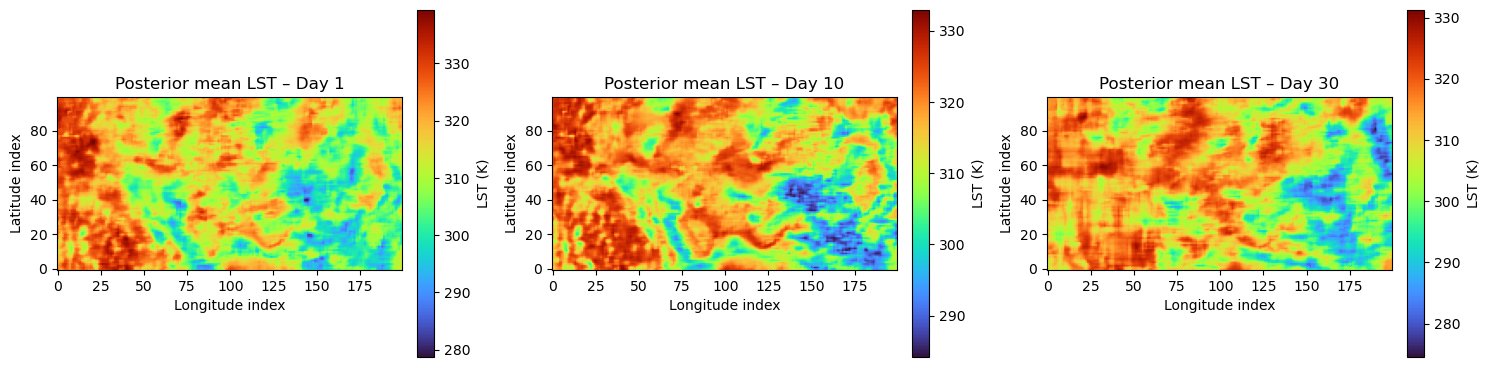

In [31]:
# Full imputed field for a few example days
import matplotlib.pyplot as plt
import numpy as np

days_to_show = [0, 9, 29]   # day indices (0-based) → days 1, 10, 30

fig, axes = plt.subplots(1, len(days_to_show), figsize=(5 * len(days_to_show), 4))

for j, d in enumerate(days_to_show):
    ax = axes[j] if len(days_to_show) > 1 else axes
    
    im = ax.imshow(m_full[:, :, d],
                   origin='lower',
                   cmap='turbo')
    ax.set_title(f"Posterior mean LST – Day {d+1}")
    ax.set_xlabel("Longitude index")
    ax.set_ylabel("Latitude index")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="LST (K)")

plt.tight_layout()
plt.show()


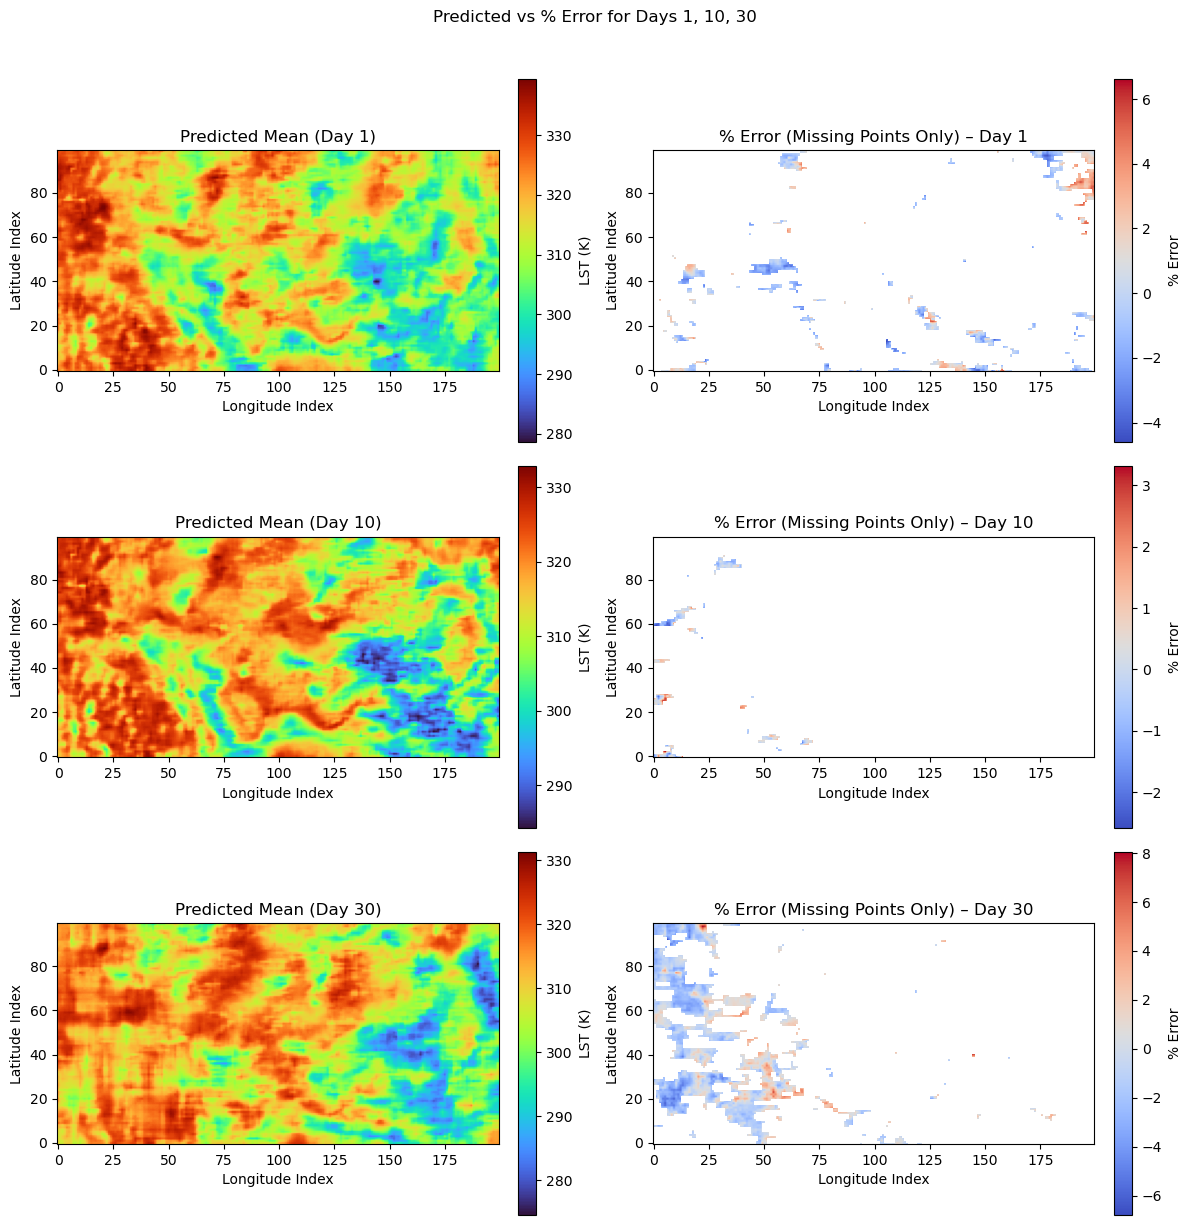

In [32]:
import matplotlib.pyplot as plt

days_to_show = [0, 9, 29]   # days 1, 10, 30
nx, ny, nt = train.shape

# Create one big figure (rows = days, cols = 2 panels)
fig, axes = plt.subplots(len(days_to_show), 2, figsize=(12, 4 * len(days_to_show)))

for row, d in enumerate(days_to_show):

    pred_day = m_full[:, :, d]
    test_day = test[:, :, d]
    train_orig = train[:, :, d]

    # Only compare where training was missing AND test has ground truth
    mask_missing = (train_orig == 0) & (test_day != 0)

    # Percentage error ONLY where valid
    perc_error = np.full((nx, ny), np.nan)
    perc_error[mask_missing] = (
        (pred_day[mask_missing] - test_day[mask_missing]) /
         test_day[mask_missing]
    ) * 100.0

    # 1) Predicted mean
    ax = axes[row, 0]
    im0 = ax.imshow(pred_day, origin="lower", cmap="turbo")
    ax.set_title(f"Predicted Mean (Day {d+1})")
    ax.set_xlabel("Longitude Index")
    ax.set_ylabel("Latitude Index")
    plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04, label="LST (K)")

    # 2) Percentage error at missing points
    ax = axes[row, 1]
    im1 = ax.imshow(np.ma.masked_invalid(perc_error),
                    origin="lower",
                    cmap="coolwarm")
    ax.set_title(f"% Error (Missing Points Only) – Day {d+1}")
    ax.set_xlabel("Longitude Index")
    ax.set_ylabel("Latitude Index")
    plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, label="% Error")

# Main title for whole figure
plt.suptitle("Predicted vs % Error for Days 1, 10, 30", y=1.02)

plt.tight_layout()
plt.savefig("predicted_vs_error_all_days.png", dpi=300, bbox_inches='tight')
plt.show()


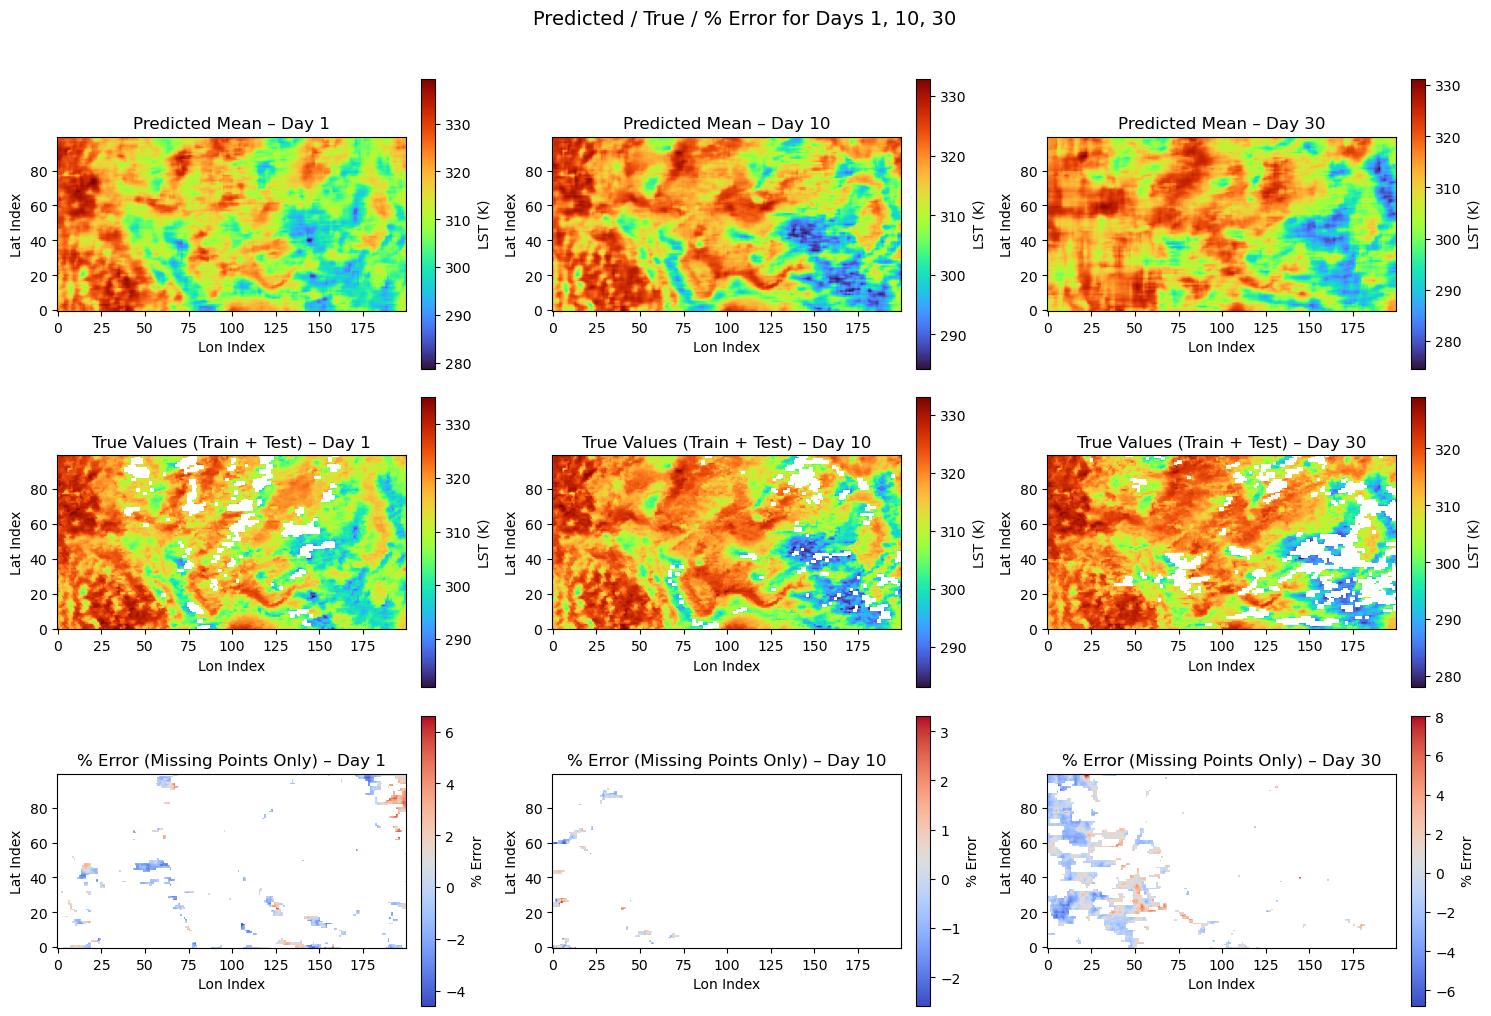

In [33]:
import numpy as np
import matplotlib.pyplot as plt

days_to_show = [0, 9, 29]   # days 1, 10, 30
nx, ny, nt = train.shape

# Create one big figure (rows = 3 panels, cols = number of days)
fig, axes = plt.subplots(3, len(days_to_show), figsize=(5 * len(days_to_show), 10))

for col, d in enumerate(days_to_show):

    pred_day  = m_full[:, :, d]
    test_day  = test[:, :, d]
    train_day = train[:, :, d]

    # --- TRUE FULL FIELD: train + test ---
    # Assumes train and test don't overlap with nonzero values
    true_day_raw = train_day + test_day
    mask_true = (true_day_raw != 0)
    true_day_plot = np.ma.masked_where(~mask_true, true_day_raw)

    # --- % ERROR: only where test has truth (i.e., missing in train) ---
    perc_error = np.full((nx, ny), np.nan)
    mask_missing = (test_day != 0)      # test provides true values only there
    perc_error[mask_missing] = (
        (pred_day[mask_missing] - true_day_raw[mask_missing]) /
         true_day_raw[mask_missing]
    ) * 100.0

    # -------- ROW 1: PREDICTED MEAN --------
    ax = axes[0, col]
    im = ax.imshow(pred_day, origin="lower", cmap="turbo")
    ax.set_title(f"Predicted Mean – Day {d+1}")
    ax.set_xlabel("Lon Index")
    ax.set_ylabel("Lat Index")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="LST (K)")

    # -------- ROW 2: TRUE VALUES (train + test) --------
    ax = axes[1, col]
    im = ax.imshow(true_day_plot, origin="lower", cmap="turbo")
    ax.set_title(f"True Values (Train + Test) – Day {d+1}")
    ax.set_xlabel("Lon Index")
    ax.set_ylabel("Lat Index")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="LST (K)")

    # -------- ROW 3: % ERROR (only where test exists) --------
    ax = axes[2, col]
    im = ax.imshow(np.ma.masked_invalid(perc_error),
                   origin="lower", cmap="coolwarm")
    ax.set_title(f"% Error (Missing Points Only) – Day {d+1}")
    ax.set_xlabel("Lon Index")
    ax.set_ylabel("Lat Index")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="% Error")

plt.suptitle("Predicted / True / % Error for Days 1, 10, 30", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig("pred_true_error_3rows_add.png", dpi=300, bbox_inches='tight')
plt.show()


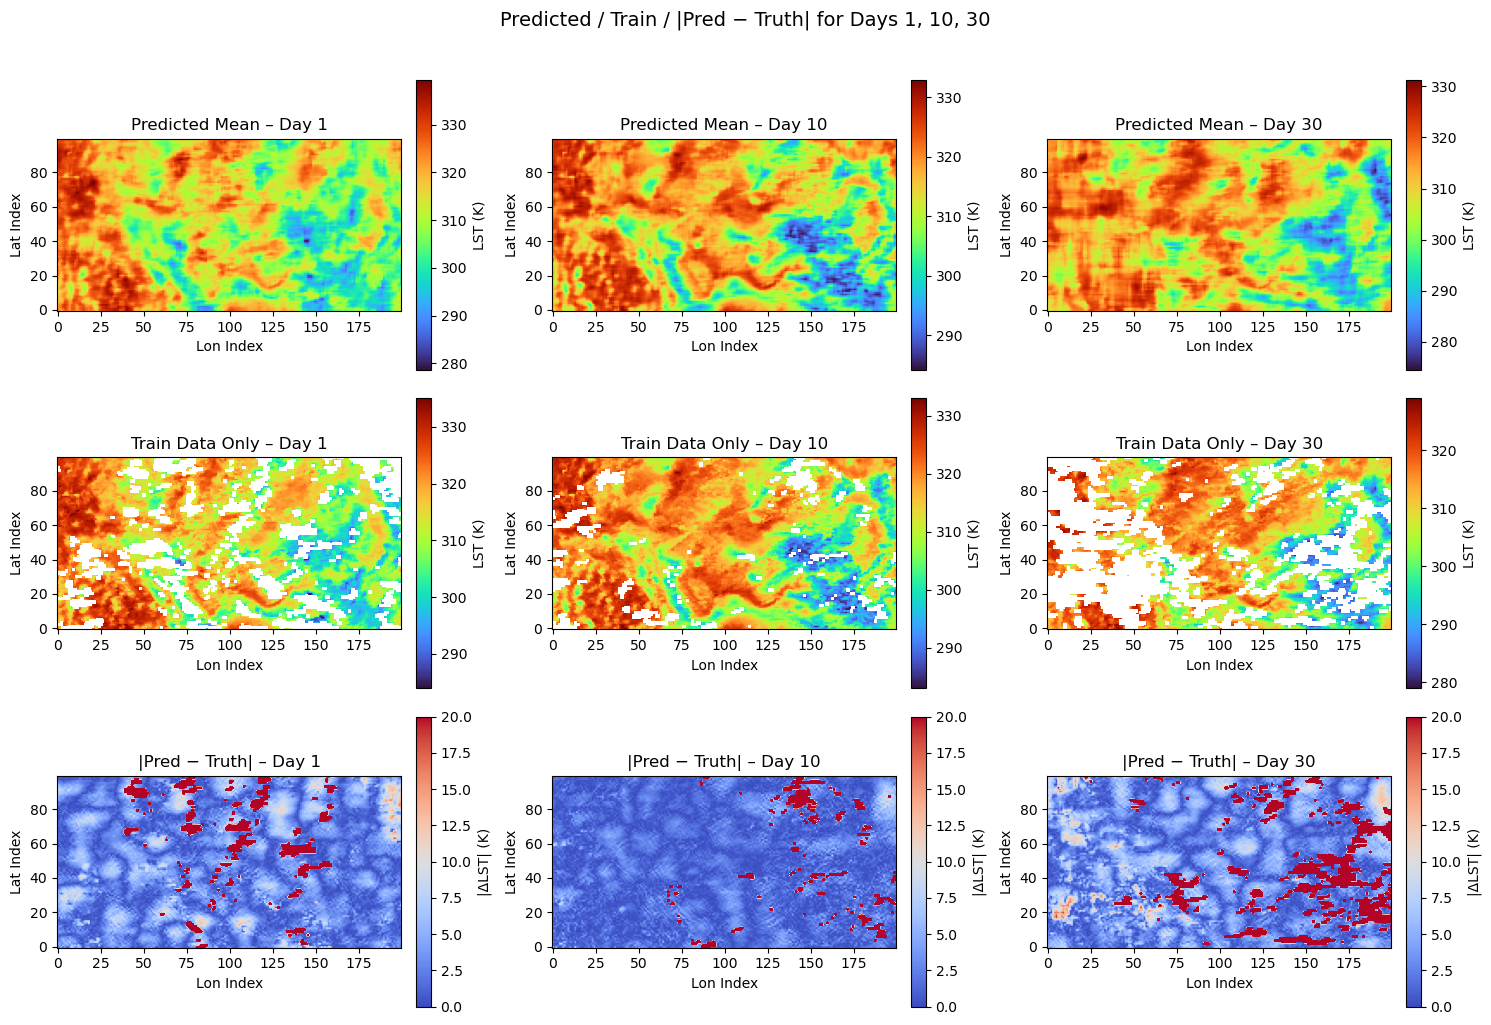

In [81]:
import numpy as np
import matplotlib.pyplot as plt

days_to_show = [0, 9, 29]   # days 1, 10, 30
nx, ny, nt = train.shape

fig, axes = plt.subplots(3, len(days_to_show), figsize=(5 * len(days_to_show), 10))

for col, d in enumerate(days_to_show):

    pred_day  = m_full[:, :, d]   # GP / Kronecker prediction
    test_day  = test[:, :, d]
    train_day = train[:, :, d]

    # --- TRUE FULL FIELD: train + test ---
    # Assumes train and test don't overlap with nonzero values
    true_day_raw = train_day + test_day

    # Mask for "any true value known" (train or test)
    mask_true = (true_day_raw != 0)
    true_day_plot = np.ma.masked_where(~mask_true, true_day_raw)

    # --- ABSOLUTE DIFFERENCE OVER ENTIRE DOMAIN ---
    # For places with no truth (true_day_raw == 0), this is |pred - 0| = |pred|
    abs_diff = np.abs(pred_day - true_day_raw)

    # -------- ROW 1: PREDICTED MEAN --------
    ax = axes[0, col]
    im = ax.imshow(pred_day, origin="lower", cmap="turbo")
    ax.set_title(f"Predicted Mean – Day {d+1}")
    ax.set_xlabel("Lon Index")
    ax.set_ylabel("Lat Index")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="LST (K)")

    # -------- ROW 2: TRAIN DATA ONLY --------
    train_mask = (train_day != 0)
    train_day_plot = np.ma.masked_where(~train_mask, train_day)

    ax = axes[1, col]
    im = ax.imshow(train_day_plot, origin="lower", cmap="turbo")
    ax.set_title(f"Train Data Only – Day {d+1}")
    ax.set_xlabel("Lon Index")
    ax.set_ylabel("Lat Index")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="LST (K)")

    # -------- ROW 3: ABSOLUTE DIFFERENCE (WHOLE DOMAIN) --------
    ax = axes[2, col]
    im = ax.imshow(abs_diff,
                   origin="lower",
                   cmap="coolwarm",      # blue–white–red
                   vmin=0, vmax=20) # fix range as requested
    ax.set_title(f"|Pred − Truth| – Day {d+1}")
    ax.set_xlabel("Lon Index")
    ax.set_ylabel("Lat Index")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="|ΔLST| (K)")

plt.suptitle("Predicted / Train / |Pred − Truth| for Days 1, 10, 30", 
             y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig("pred_train_absdiff_3rows.png", dpi=300, bbox_inches='tight')
plt.show()


In [34]:
# looking for days that have uncertainty calculated

idx_lat, idx_lon, idx_time = np.unravel_index(subset_idx_flat, train.shape)
pred_means_sub
pred_vars_sub

unique_days_with_var = np.unique(idx_time)
print(unique_days_with_var)

[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


In [35]:
days_to_show = unique_days_with_var[:3]
print("Days chosen for uncertainty plots:", days_to_show)

# Turn subset indices into (lat, lon, time)
idx_lat, idx_lon, idx_time = np.unravel_index(subset_idx_flat, train.shape)

unique_days, counts = np.unique(idx_time, return_counts=True)
print("Day index (0-based) -> count of subset points:")
for d, c in zip(unique_days, counts):
    print(f"  Day {d} (Day {d+1} in 1-based) : {c} points")

# Pick the day with the maximum number of points
max_idx = np.argmax(counts)
best_day = unique_days[max_idx]
best_count = counts[max_idx]
print(f"\nBest day is Day {best_day} (Day {best_day+1}) with {best_count} points.")


Days chosen for uncertainty plots: [0 1 2]
Day index (0-based) -> count of subset points:
  Day 0 (Day 1 in 1-based) : 9 points
  Day 1 (Day 2 in 1-based) : 8 points
  Day 2 (Day 3 in 1-based) : 3 points
  Day 3 (Day 4 in 1-based) : 28 points
  Day 4 (Day 5 in 1-based) : 18 points
  Day 6 (Day 7 in 1-based) : 1 points
  Day 7 (Day 8 in 1-based) : 1 points
  Day 8 (Day 9 in 1-based) : 1 points
  Day 9 (Day 10 in 1-based) : 7 points
  Day 10 (Day 11 in 1-based) : 1 points
  Day 11 (Day 12 in 1-based) : 20 points
  Day 12 (Day 13 in 1-based) : 35 points
  Day 13 (Day 14 in 1-based) : 58 points
  Day 14 (Day 15 in 1-based) : 20 points
  Day 15 (Day 16 in 1-based) : 27 points
  Day 16 (Day 17 in 1-based) : 20 points
  Day 17 (Day 18 in 1-based) : 19 points
  Day 18 (Day 19 in 1-based) : 27 points
  Day 19 (Day 20 in 1-based) : 7 points
  Day 20 (Day 21 in 1-based) : 10 points
  Day 21 (Day 22 in 1-based) : 16 points
  Day 22 (Day 23 in 1-based) : 16 points
  Day 23 (Day 24 in 1-based) : 41 

Days with subset uncertainty points: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Plotting uncertainty for days: [13]
Day 14: number of subset points = 58


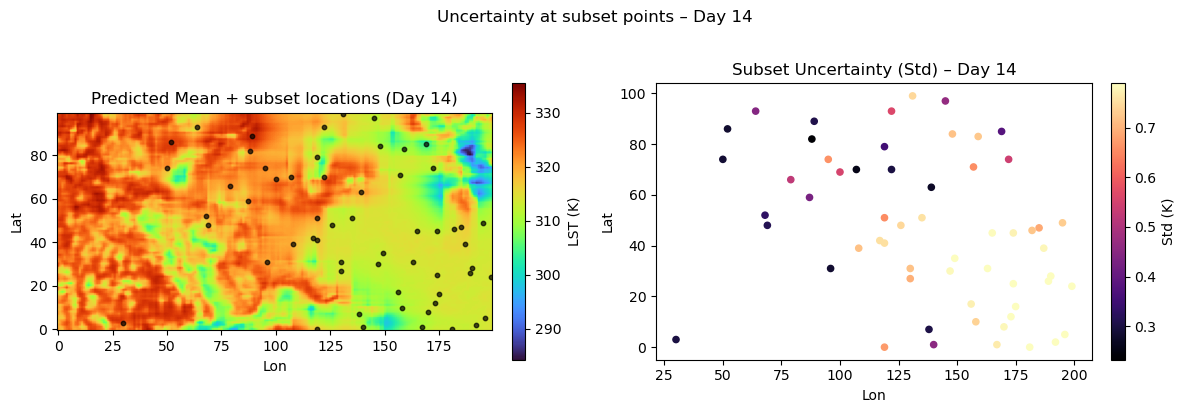

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# idx_lat, idx_lon, idx_time, pred_means_sub, pred_vars_sub already exist

unique_days_with_var = np.unique(idx_time)
print("Days with subset uncertainty points:", unique_days_with_var)

# choose (for example) up to 3 days that actually have points
#days_to_show = unique_days_with_var[:3]
#days_to_show = [13]
days_to_show = [best_day]
print("Plotting uncertainty for days:", days_to_show)

nx, ny, nt = train.shape

for d in days_to_show:
    mask_day_sub = (idx_time == d)
    n_points = np.sum(mask_day_sub)
    print(f"Day {d+1}: number of subset points =", n_points)

    if n_points == 0:
        print(f"  (Skipping day {d+1} – no subset points)")
        continue

    lat_d = idx_lat[mask_day_sub]
    lon_d = idx_lon[mask_day_sub]
    means_d = pred_means_sub[mask_day_sub]
    vars_d  = pred_vars_sub[mask_day_sub]

    std_d = np.sqrt(np.maximum(vars_d, 0.0))

    # For context, also get the full predicted field for that day
    pred_day = m_full[:, :, d]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 1) Background: full predicted field
    ax = axes[0]
    im0 = ax.imshow(pred_day, origin="lower", cmap="turbo")
    ax.scatter(lon_d, lat_d, c="k", s=10, alpha=0.7)
    ax.set_title(f"Predicted Mean + subset locations (Day {d+1})")
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04, label="LST (K)")

    # 2) Scatter of uncertainty at subset points
    ax = axes[1]
    sc = ax.scatter(lon_d, lat_d, c=std_d, cmap="magma", s=20)
    ax.set_title(f"Subset Uncertainty (Std) – Day {d+1}")
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="Std (K)")

    plt.suptitle(f"Uncertainty at subset points – Day {d+1}", y=1.02)
    plt.tight_layout()
    plt.show()


In [37]:

# Turn subset indices into (lat, lon, time)
idx_lat, idx_lon, idx_time = np.unravel_index(subset_idx_flat, train.shape)

unique_days, counts = np.unique(idx_time, return_counts=True)
print("Day index (0-based) -> count of subset points:")
for d, c in zip(unique_days, counts):
    print(f"  Day {d} (Day {d+1} in 1-based) : {c} points")

# Pick the day with the maximum number of points
max_idx = np.argmax(counts)
best_day = unique_days[max_idx]
best_count = counts[max_idx]
print(f"\nBest day is Day {best_day} (Day {best_day+1}) with {best_count} points.")


Day index (0-based) -> count of subset points:
  Day 0 (Day 1 in 1-based) : 9 points
  Day 1 (Day 2 in 1-based) : 8 points
  Day 2 (Day 3 in 1-based) : 3 points
  Day 3 (Day 4 in 1-based) : 28 points
  Day 4 (Day 5 in 1-based) : 18 points
  Day 6 (Day 7 in 1-based) : 1 points
  Day 7 (Day 8 in 1-based) : 1 points
  Day 8 (Day 9 in 1-based) : 1 points
  Day 9 (Day 10 in 1-based) : 7 points
  Day 10 (Day 11 in 1-based) : 1 points
  Day 11 (Day 12 in 1-based) : 20 points
  Day 12 (Day 13 in 1-based) : 35 points
  Day 13 (Day 14 in 1-based) : 58 points
  Day 14 (Day 15 in 1-based) : 20 points
  Day 15 (Day 16 in 1-based) : 27 points
  Day 16 (Day 17 in 1-based) : 20 points
  Day 17 (Day 18 in 1-based) : 19 points
  Day 18 (Day 19 in 1-based) : 27 points
  Day 19 (Day 20 in 1-based) : 7 points
  Day 20 (Day 21 in 1-based) : 10 points
  Day 21 (Day 22 in 1-based) : 16 points
  Day 22 (Day 23 in 1-based) : 16 points
  Day 23 (Day 24 in 1-based) : 41 points
  Day 24 (Day 25 in 1-based) : 15 po

Std range: 0.0 0.7893847884279208
Abs error range: 0.004464534915484819 20.10796645138032


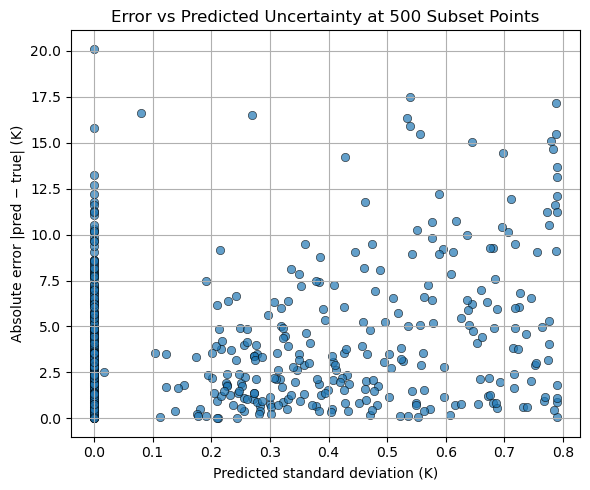

In [38]:
# error vs std scatter
import numpy as np
import matplotlib.pyplot as plt

# True values at the 500 subset points
y_true_sub = test.ravel()[subset_idx_flat]

# Predicted mean and std at those points
y_pred_sub = pred_means_sub
std_sub    = np.sqrt(np.maximum(pred_vars_sub, 0.0))

# Absolute error
abs_err_sub = np.abs(y_pred_sub - y_true_sub)

print("Std range:", std_sub.min(), std_sub.max())
print("Abs error range:", abs_err_sub.min(), abs_err_sub.max())

plt.figure(figsize=(6, 5))
plt.scatter(std_sub, abs_err_sub, alpha=0.7, edgecolors="k", linewidths=0.5)
plt.xlabel("Predicted standard deviation (K)")
plt.ylabel("Absolute error |pred − true| (K)")
plt.title("Error vs Predicted Uncertainty at 500 Subset Points")
plt.grid(True)

plt.tight_layout()
plt.show()


In [39]:
# Pick 3 locations from the 500 points
nx, ny, nt = train.shape

# We already have: pred_vars_sub (variance at those specific 3D points)

# Turn (lat, lon) into a single code so we can group by location
loc_codes = idx_lat * ny + idx_lon   # unique code for each spatial cell

# For each spatial location, find max variance over the subset points that hit it
unique_locs, inv = np.unique(loc_codes, return_inverse=True)
max_var_per_loc = np.zeros(unique_locs.size)
for i_loc in range(unique_locs.size):
    max_var_per_loc[i_loc] = np.max(pred_vars_sub[inv == i_loc])

# Pick the top-2 most uncertain locations (spatially)
top_k = 2
top_loc_indices = np.argsort(max_var_per_loc)[-top_k:]
print("Chosen top locations (indices in unique_locs):", top_loc_indices)

# Decode these back to (lat, lon)
top_lats = (unique_locs[top_loc_indices] // ny)
top_lons = (unique_locs[top_loc_indices] % ny)

for i in range(top_k):
    print(f"Location {i}: lat={top_lats[i]}, lon={top_lons[i]}")


Chosen top locations (indices in unique_locs): [109  30]
Location 0: lat=24, lon=199
Location 1: lat=5, lon=196


In [40]:
#For each chosen location, compute mean & variance over all 31 days
prior_var_point = var_x * var_y * var_t
print("Prior variance per point:", prior_var_point)

# compute a time series:
nt = train.shape[2]
n_locs = top_k

means_ts = np.zeros((n_locs, nt))
vars_ts  = np.zeros((n_locs, nt))
truth_ts = np.zeros((n_locs, nt))
mask_truth_ts = np.zeros((n_locs, nt), dtype=bool)

for li in range(n_locs):
    iy = int(top_lats[li])
    ix = int(top_lons[li])
    print(f"\nComputing time series for location {li}: lat={iy}, lon={ix}")

    for t in range(nt):
        idx_star = np.ravel_multi_index((iy, ix, t), train.shape)

        # predictive mean already in m_full
        means_ts[li, t] = m_full[iy, ix, t]

        # truth (if available in test)
        truth_val = test[iy, ix, t]
        truth_ts[li, t] = truth_val
        mask_truth_ts[li, t] = (truth_val != 0)

        # === variance via CG ===
        # standard trick: k_full(:, x*) = K_full @ e_*
        e_full = np.zeros(train.size, dtype=np.float64)
        e_full[idx_star] = 1.0

        k_full_col = kron_mv(Kx, Ky, Kt, e_full)   # length nx*ny*nt
        k_o_star   = k_full_col[obs_idx]           # restrict to observed indices

        # (K_oo + noise_var I) v = k_o_star
        v_star, info_v = cg(Koo_op, k_o_star, maxiter=200, rtol=1e-2)
        if info_v != 0:
            print(f"  [warning] CG for variance at (loc {li}, t {t}) info={info_v}")

        # var = prior_var - k_*o v
        vars_ts[li, t] = prior_var_point - np.dot(k_o_star, v_star)

# Clip negative variances (numerical issues)
vars_ts = np.maximum(vars_ts, 0.0)
std_ts  = np.sqrt(vars_ts)


Prior variance per point: 0.6370131024152245

Computing time series for location 0: lat=24, lon=199
  [warning] CG for variance at (loc 0, t 9) info=200
  [warning] CG for variance at (loc 0, t 10) info=200
  [warning] CG for variance at (loc 0, t 11) info=200
  [warning] CG for variance at (loc 0, t 12) info=200
  [warning] CG for variance at (loc 0, t 14) info=200
  [warning] CG for variance at (loc 0, t 15) info=200
  [warning] CG for variance at (loc 0, t 16) info=200
  [warning] CG for variance at (loc 0, t 17) info=200
  [warning] CG for variance at (loc 0, t 18) info=200
  [warning] CG for variance at (loc 0, t 19) info=200
  [warning] CG for variance at (loc 0, t 20) info=200
  [warning] CG for variance at (loc 0, t 21) info=200
  [warning] CG for variance at (loc 0, t 22) info=200
  [warning] CG for variance at (loc 0, t 23) info=200

Computing time series for location 1: lat=5, lon=196
  [warning] CG for variance at (loc 1, t 10) info=200
  [warning] CG for variance at (loc 1

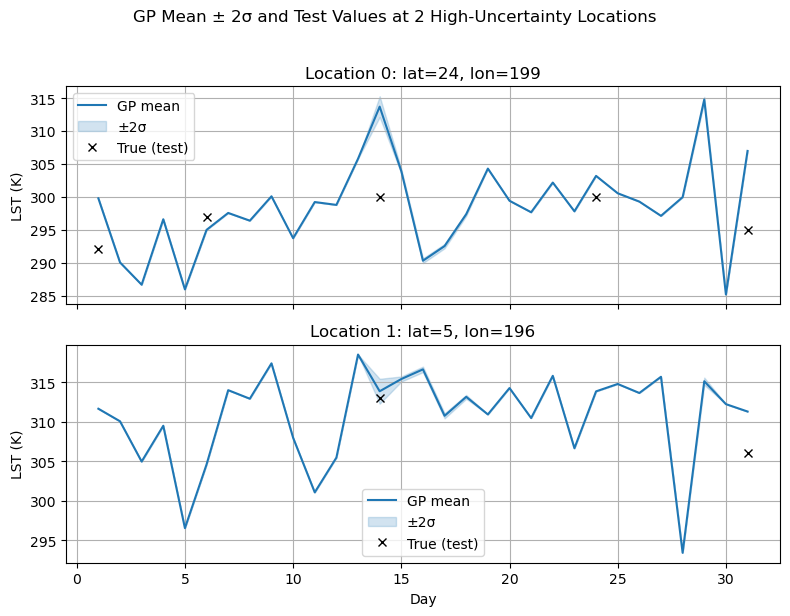

In [41]:
# Plot time series mean ± 2σ and truth
days = np.arange(1, nt+1)

fig, axes = plt.subplots(n_locs, 1, figsize=(8, 3 * n_locs), sharex=True)

if n_locs == 1:
    axes = [axes]

for li in range(n_locs):
    ax = axes[li]

    mu = means_ts[li]
    sd = std_ts[li]
    lower = mu - 2*sd
    upper = mu + 2*sd

    ax.plot(days, mu, label="GP mean", color="C0")
    ax.fill_between(days, lower, upper, color="C0", alpha=0.2, label="±2σ")

    # Plot truth where available
    mask_t = mask_truth_ts[li]
    if np.any(mask_t):
        ax.plot(days[mask_t],
                truth_ts[li, mask_t],
                "kx",
                label="True (test)")

    ax.set_title(f"Location {li}: lat={top_lats[li]}, lon={top_lons[li]}")
    ax.set_ylabel("LST (K)")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Day")
plt.suptitle("GP Mean ± 2σ and Test Values at 2 High-Uncertainty Locations", y=1.02)
plt.tight_layout()
plt.show()


**Compare with test tensor**

In [43]:
# mean values
mask_test = test != 0

y_true = test[mask_test]
y_pred = m_full[mask_test]

rmse = np.sqrt(np.mean((y_pred - y_true)**2))
r2   = 1.0 - np.sum((y_pred - y_true)**2) / np.sum((y_true - y_true.mean())**2)

print(f"Test RMSE: {rmse:.3f} K")
print(f"Test R^2:  {r2:.3f}")

Test RMSE: 5.386 K
Test R^2:  0.602


In [44]:
# CRPS
from scipy.stats import norm

def crps_gaussian(mu, sigma, y):
    """CRPS for a Gaussian predictive distribution."""
    z = (y - mu) / sigma
    return sigma * (z*(2*norm.cdf(z)-1) + 2*norm.pdf(z) - 1/np.sqrt(np.pi))

# Compute CRPS for all 500 points
crps_values = crps_gaussian(y_pred_sub, std_sub, y_true_sub)

print("Mean CRPS:", np.mean(crps_values))
print("Median CRPS:", np.median(crps_values))
print("Min CRPS:", np.min(crps_values))
print("Max CRPS:", np.max(crps_values))


Mean CRPS: nan
Median CRPS: nan
Min CRPS: nan
Max CRPS: nan


C:\Users\zsamet\AppData\Local\Temp\ipykernel_3400\883673926.py:6: RuntimeWarning: divide by zero encountered in divide
  z = (y - mu) / sigma
C:\Users\zsamet\AppData\Local\Temp\ipykernel_3400\883673926.py:7: RuntimeWarning: invalid value encountered in multiply
  return sigma * (z*(2*norm.cdf(z)-1) + 2*norm.pdf(z) - 1/np.sqrt(np.pi))


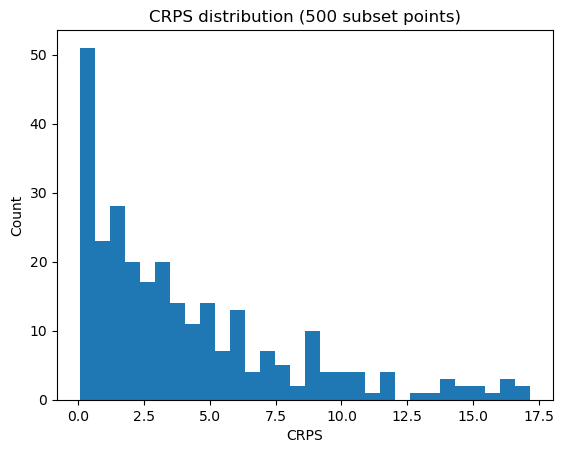

In [45]:
plt.hist(crps_values, bins=30)
plt.xlabel("CRPS")
plt.ylabel("Count")
plt.title("CRPS distribution (500 subset points)")
plt.show()
